# Clinical NLP to predict readmission with discharge summaries<span class="tocSkip"></span></h1>

In [123]:
import pandas as pd
import numpy as np
# For interacting with PostgreSQL database for mimic queries
import psycopg2

# Ploting functions
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

plotly.tools.set_credentials_file(username='mlpaff', api_key='lYV8hhGxZlP988tplymj')
plotly.tools.set_config_file(world_readable=True,
                             sharing='public')

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(20, 10)
plt.style.use(['dark_background'])

from sklearn.model_selection import train_test_split 

color_set = ['#A9CA59', '#6582C4', '#62C9BC', '#F58D50', '#2AD7F4',
             '#AB3EED', '#FF6CB2', '#FFA466', '#FFE256', '#47EAAC', '#2AD7F4', '#3C8CF9']

# specify user and database for SQL queries
sqluser = 'mattmimic'
dbname = 'mimic'
set_schema = '--search_path=mimiciii'

# Connect to the database
# con = psycopg2.connect(dbname = dbname, user = sqluser, options = set_schema)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Admissions-table" data-toc-modified-id="Admissions-table-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Admissions table</a></span></li><li><span><a href="#NOTEEVENTS-table" data-toc-modified-id="NOTEEVENTS-table-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NOTEEVENTS table</a></span><ul class="toc-item"><li><span><a href="#Merge-notes-with-admissions-table" data-toc-modified-id="Merge-notes-with-admissions-table-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Merge notes with admissions table</a></span></li></ul></li><li><span><a href="#Create-training-and-test-dataframes" data-toc-modified-id="Create-training-and-test-dataframes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create training and test dataframes</a></span></li><li><span><a href="#Preprocess-text-data" data-toc-modified-id="Preprocess-text-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocess text data</a></span></li><li><span><a href="#Build-a-tokenizer" data-toc-modified-id="Build-a-tokenizer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build a tokenizer</a></span><ul class="toc-item"><li><span><a href="#Customize-tokenizer" data-toc-modified-id="Customize-tokenizer-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Customize tokenizer</a></span></li></ul></li><li><span><a href="#Build-a-simple-vectorizer" data-toc-modified-id="Build-a-simple-vectorizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Build a simple vectorizer</a></span><ul class="toc-item"><li><span><a href="#Build-a-vectorizer-on-clinical-notes" data-toc-modified-id="Build-a-vectorizer-on-clinical-notes-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Build a vectorizer on clinical notes</a></span></li></ul></li><li><span><a href="#Build-simple-predictive-model" data-toc-modified-id="Build-simple-predictive-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Build simple predictive model</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model evaluation</a></span></li><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Word2Vec</a></span><ul class="toc-item"><li><span><a href="#W2V-preprocessing-of-text" data-toc-modified-id="W2V-preprocessing-of-text-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>W2V preprocessing of text</a></span><ul class="toc-item"><li><span><a href="#Word-2-Vec-implementation" data-toc-modified-id="Word-2-Vec-implementation-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>Word 2 Vec implementation</a></span></li></ul></li></ul></li><li><span><a href="#Train-a-simple-model" data-toc-modified-id="Train-a-simple-model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Train a simple model</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Model evaluation</a></span></li></ul></div>

# Admissions table

In [74]:
con = psycopg2.connect(dbname = dbname, user = sqluser, options = set_schema)
query = 'SELECT subject_id, hadm_id, admittime, dischtime, deathtime, admission_type FROM admissions;'
admissions = pd.read_sql_query(query, con, parse_dates=['admittime', 'dischtime', 'deathtime'])
con.close()

# we will drop all patients that had negative

admissions.sort_values(['subject_id', 'admittime'], inplace=True)

# Create a column for next admission time (if it exists)
admissions['next_admittime'] = admissions.groupby('subject_id')['admittime'].shift(-1)
# Get the next admission type
admissions['next_admit_type'] = admissions.groupby('subject_id')['admission_type'].shift(-1)

admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,next_admittime,next_admit_type
212,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN
213,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN
214,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN
215,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN
216,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN


In [75]:
# Filter out elective emissions since we are interested in uplanned re-admissions
rows = admissions['next_admit_type'] == 'ELECTIVE'
admissions.loc[rows, 'next_admittime'] = pd.NaT
admissions.loc[rows, 'next_admit_type'] = np.NaN

# Sort by subject_id and admission date
admissions.sort_values(['subject_id', 'admittime'])

# back fill
admissions[['next_admittime', 'next_admit_type']] = admissions.groupby('subject_id')[['next_admittime', 'next_admit_type']].fillna(method='bfill')
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,next_admittime,next_admit_type
212,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN
213,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN
214,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN
215,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN
216,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN


In [76]:
# Calculate the days until the next admission
admissions['days_next_admit'] = (admissions.next_admittime - admissions.dischtime).dt.total_seconds() / (24*60*60)
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,next_admittime,next_admit_type,days_next_admit
212,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN,NaN
213,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN
214,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN
215,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN,NaN
216,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN


In [77]:
# hist_data = [admissions.days_next_admit.dropna()]
# fig = ff.create_distplot(hist_data, group_labels=['Days between Admissions'], show_rug=False, bin_size=100)

trace = go.Histogram(
    x = admissions['days_next_admit']
)
layout = go.Layout(
    xaxis = dict(
        title = 'Days between Admissions'
    ),
    yaxis = dict(
        title = 'Count'
    )
)

fig = go.Figure(data = [trace], layout = layout)

iplot(fig)

# NOTEEVENTS table

In [32]:
con = psycopg2.connect(dbname = dbname, user = sqluser, options = set_schema)
query = 'SELECT * FROM noteevents;'
notes = pd.read_sql_query(query, con)
con.close()
notes.head()

CPU times: user 26.1 s, sys: 1min 38s, total: 2min 4s
Wall time: 6min 11s


In [66]:
# Filter to discharge summary notes only
dis_notes = notes[notes['category'] == 'Discharge summary'].copy()

In [67]:
assert dis_notes.duplicated(['hadm_id']).sum() == 0, 'Multiple discharge summaries per admission'

AssertionError: Multiple discharge summaries per admission

In [68]:
dis_notes[dis_notes['hadm_id'] == 172599.0]
# admissions[admissions['hadm_id'] == 172599.0]
# dis_notes[dis_notes['hadm_id'] == 172599.0].text.iloc[-1]

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text
52624,49176,25030,172599.0,2116-06-08,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2116-5-21**] Dischar...
52625,49177,25030,172599.0,2116-06-08,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2116-5-21**] Dischar...
52626,49178,25030,172599.0,2116-07-23,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2116-5-21**] Dischar...
52627,49179,25030,172599.0,2116-07-23,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2116-5-21**] Dischar...
53112,49206,25030,172599.0,2116-07-23,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: Discharge Da...
58596,59151,25030,172599.0,2116-06-17,NaT,NaT,Discharge summary,Addendum,NaN,None,"Name: [**Known lastname **], [**Known firstna..."
58597,59152,25030,172599.0,2116-07-06,NaT,NaT,Discharge summary,Addendum,NaN,None,"Name: [**Known lastname **], [**Known firstna..."


In [69]:
# Grab just the last discharge summaries by hadm_id
last_dis_notes = dis_notes.groupby(['subject_id', 'hadm_id']).nth(-1).reset_index()
assert last_dis_notes.duplicated(['hadm_id']).sum() == 0, 'Multiple discharge summaries per admission'

## Merge notes with admissions table

In [78]:
adm_notes = admissions.merge(last_dis_notes, on = ['subject_id', 'hadm_id'], how = 'left')

assert len(admissions) == len(adm_notes), 'Number of rows increased'

In [79]:
adm_notes.text.isnull().sum() / len(adm_notes)

0.1059753119913185

In [72]:
list(adm_notes.admission_type.unique())

['EMERGENCY', 'ELECTIVE', 'NEWBORN', 'URGENT']

In [80]:
# Remove Newborn admissions
adm_notes = adm_notes[adm_notes['admission_type'] != 'NEWBORN']
adm_notes.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,next_admittime,next_admit_type,days_next_admit,category,cgid,chartdate,charttime,description,iserror,row_id,storetime,text
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,NaN,2101-10-31,NaT,Report,None,44005.0,NaT,Admission Date: [**2101-10-20**] Discharg...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,NaN,2191-03-23,NaT,Report,None,4788.0,NaT,Admission Date: [**2191-3-16**] Discharge...
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN,Discharge summary,NaN,2175-06-15,NaT,Report,None,20825.0,NaT,Admission Date: [**2175-5-30**] Dischar...
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN,Discharge summary,NaN,2149-11-14,NaT,Addendum,None,57115.0,NaT,"Name: [**Known lastname 10050**], [**Known fi..."
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,NaN,2178-05-11,NaT,Report,None,30120.0,NaT,Admission Date: [**2178-4-16**] ...


In [81]:
adm_notes['output_label'] = (adm_notes['days_next_admit'] < 30).astype('int')
adm_notes.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,next_admittime,next_admit_type,days_next_admit,category,cgid,chartdate,charttime,description,iserror,row_id,storetime,text,output_label
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,NaN,2101-10-31,NaT,Report,None,44005.0,NaT,Admission Date: [**2101-10-20**] Discharg...,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,NaN,2191-03-23,NaT,Report,None,4788.0,NaT,Admission Date: [**2191-3-16**] Discharge...,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN,Discharge summary,NaN,2175-06-15,NaT,Report,None,20825.0,NaT,Admission Date: [**2175-5-30**] Dischar...,0
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN,Discharge summary,NaN,2149-11-14,NaT,Addendum,None,57115.0,NaT,"Name: [**Known lastname 10050**], [**Known fi...",0
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,NaN,2178-05-11,NaT,Report,None,30120.0,NaT,Admission Date: [**2178-4-16**] ...,0


In [82]:
print('number of patients that were re-admitted within 30 days:', len(adm_notes[adm_notes['output_label'] == 1]))
print('fraction of patients re-admitted within 30 days:', len(adm_notes[adm_notes['output_label'] == 1]) / len(adm_notes))

number of patients that were re-admitted within 30 days: 3004
fraction of patients re-admitted within 30 days: 0.05877174104435271


In [83]:
adm_notes[(adm_notes['output_label'] == 1) & (adm_notes['admission_type'] == 'ELECTIVE')]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,next_admittime,next_admit_type,days_next_admit,category,cgid,chartdate,charttime,description,iserror,row_id,storetime,text,output_label
288,222,137006,2142-06-11 07:15:00,2142-06-19 12:30:00,NaT,ELECTIVE,2142-06-23 05:02:00,EMERGENCY,3.688889,Discharge summary,NaN,2142-06-19,NaT,Addendum,None,59102.0,NaT,"Name: [**Known lastname 16484**],[**Known fir...",1
363,287,174293,2167-05-22 07:15:00,2167-05-27 16:16:00,NaT,ELECTIVE,2167-05-31 13:22:00,EMERGENCY,3.879167,Discharge summary,NaN,2167-05-27,NaT,Report,None,16060.0,NaT,Admission Date: [**2167-5-22**] Dischar...,1
782,634,168186,2116-07-17 07:15:00,2116-07-26 15:45:00,NaT,ELECTIVE,2116-08-03 10:47:00,EMERGENCY,7.793056,Discharge summary,NaN,2116-07-26,NaT,Report,None,15629.0,NaT,Admission Date: [**2116-7-17**] Dischar...,1
961,781,148270,2117-08-17 07:15:00,2117-09-08 15:00:00,NaT,ELECTIVE,2117-09-10 23:04:00,EMERGENCY,2.336111,Discharge summary,NaN,2117-09-08,NaT,Report,None,21864.0,NaT,Admission Date: [**2117-8-17**] ...,1
964,782,125662,2176-02-12 07:15:00,2176-02-23 15:40:00,NaT,ELECTIVE,2176-03-04 14:54:00,EMERGENCY,9.968056,Discharge summary,NaN,2176-02-23,NaT,Report,None,13843.0,NaT,Admission Date: [**2176-2-12**] Dischar...,1
1054,852,133054,2156-03-23 11:30:00,2156-03-28 14:15:00,NaT,ELECTIVE,2156-04-02 18:27:00,EMERGENCY,5.175000,Discharge summary,NaN,2156-03-28,NaT,Report,None,45510.0,NaT,Admission Date: [**2156-3-23**] ...,1
1238,998,171544,2153-09-05 09:00:00,2153-09-18 15:30:00,NaT,ELECTIVE,2153-10-07 13:57:00,EMERGENCY,18.935417,Discharge summary,NaN,2153-09-18,NaT,Report,None,12863.0,NaT,Admission Date: [**2153-9-5**] Discharg...,1
1245,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaT,ELECTIVE,2108-06-07 21:52:00,EMERGENCY,13.244444,Discharge summary,NaN,2108-05-25,NaT,Report,None,29254.0,NaT,Admission Date: [**2108-5-10**] ...,1
1508,1220,113887,2181-08-08 08:00:00,2181-08-14 12:30:00,NaT,ELECTIVE,2181-09-12 15:37:00,EMERGENCY,29.129861,Discharge summary,NaN,2181-08-14,NaT,Report,None,3195.0,NaT,Admission Date: [**2181-8-8**] Discharg...,1
1648,1339,192698,2138-09-11 00:16:00,2138-09-20 12:30:00,NaT,ELECTIVE,2138-09-22 08:36:00,EMERGENCY,1.837500,Discharge summary,NaN,2138-09-20,NaT,Report,None,50584.0,NaT,Admission Date: [**2138-9-11**] ...,1


# Create training and test dataframes

In [84]:
# Split data into train, validation and test sets

# shuffle the samples
adm_notes = adm_notes.sample(n = len(adm_notes), random_state=42)
adm_notes.reset_index(drop=True, inplace=True)

In [122]:


target = adm_notes[['output_label']]
data = adm_notes[['subject_id', 'hadm_id', 'text']]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state = 3)

# Preprocess text data

In [107]:
def preprocess_text(df):
    ''' Preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    '''
    
    df['text'] = df['text'].fillna(' ')
    df['text'] = df['text'].str.replace('\n', ' ')
    df['text'] = df['text'].str.replace('\r', ' ')
    return df

In [108]:
X_test, X_train = preprocess_text(X_test), preprocess_text(X_train)

# Build a tokenizer

In [109]:
import nltk
from nltk import word_tokenize
# nltk.download()

In [110]:
word_tokenize('This should be tokenized. 11/14/2018 sentence has stars **')

['This',
 'should',
 'be',
 'tokenized',
 '.',
 '11/14/2018',
 'sentence',
 'has',
 'stars',
 '**']

## Customize tokenizer 
- replace punctuation with spaces
- remove numbers with spaces
- lowercase all words

In [111]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [112]:
def tokenizeBetter(text):
    ''' Tokenize the text by replacing punctuations and numbers with spaces and lowercase all words
    '''
    punc_list = string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ' '))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [113]:
tokenizeBetter('This should be tokenized. 11/14/2018 sentence has stars***')

['this', 'should', 'be', 'tokenized', 'sentence', 'has', 'stars']

# Build a simple vectorizer

In [114]:
sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenizeBetter)
vect.fit(sample_text)

# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)

In [116]:
X.toarray()

array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]])

In [117]:
# get the column names
vect.get_feature_names()

['about',
 'amazing',
 'data',
 'is',
 'modeling',
 'of',
 'part',
 'predictive',
 'science',
 'the']

## Build a vectorizer on clinical notes
- Using the tokenizer we defined above as part of the pipeline, we can vectorize at the same time

In [118]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

In [119]:
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizeBetter,
                       stop_words = my_stop_words)

vect.fit(X_train['text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name', 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am', 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date', 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o', 'namepattern', 'which', 'every', 'also'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizeBetter at 0x1a25f10ae8>,
        vocabulary=None)

In [120]:
X_train_tf = vect.transform(X_train['text'].values)
X_train_tf

<40890x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 17238962 stored elements in Compressed Sparse Row format>

# Build simple predictive model

In [121]:
# Logistic regression
from sklearn.linear_model import LogisticRegression as LR

clf = LR(C = 0.0001, penalty = 'l2', random_state = 3, class_weight="balanced")
clf.fit(X_train_tf, y_train)

model = clf

y_train_preds = model.predict_proba(X_train_tf)[:,1]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [131]:
y_train_preds

array([0.47002937, 0.31576863, 0.33209323, ..., 0.61191118, 0.43283875,
       0.79852759])

# Model evaluation

In [126]:
from sklearn.metrics import roc_curve, roc_auc_score

def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [139]:
# fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)

# thresh = 0.5

# auc_train = roc_auc_score(y_train, y_train_preds)
# print('Train AUC: %.3f'%auc_train)

# print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
# print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
# print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
# print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
# print('Train prevalence:%.3f'%calc_prevalence(y_train))

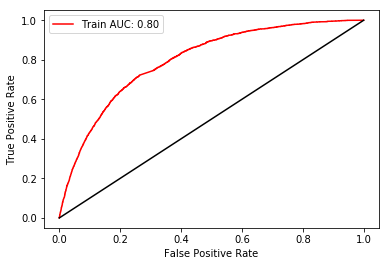

In [129]:
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
# plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Word2Vec

In [143]:
from gensim.models import Word2Vec
from gensim.models import word2vec
import re

nltk.download('punkt')
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /Users/mattpaff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## W2V preprocessing of text
- Here we want to convert everything to lowercase and convert to list of sentences.

In [261]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also', 'b', 'i', 'd', 'admission', 'q', 't']

In [307]:
def w2vTokenizer(sentence):
    ''' Tokenize the text by replacing punctuations and numbers with spaces and lowercase all words
    '''
    punc_list = string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ' '))
    text = str(sentence).lower().translate(t)
    tokens = [x for x in word_tokenize(text.strip()) if x not in my_stop_words]
#     tokens = word_tokenize(text)
    return tokens

In [253]:
# def sentence_to_wordlist(sentence, remove_stopwords=False):
#     # remove non-letters
#     sentence_text = re.sub(r'[^\w\s]', '', sentence)
#     #convert words to lowercase and split them
#     words = sentence_text.lower().split()
    
#     return words

def notes_to_sentences(notes, tokenizer, remove_stopwords=False):
    try:
        # use NLTK tokenizer to split the text into sentences
        raw_sentences = tokenizer.tokenize(notes)
        
        # Loop over each sentence
        sentences = []
        for sent in raw_sentences:
            # if sentence is empty, skip it
            if len(sent) > 0:
                tokens = [x for x in w2vTokenizer(sent.strip()) if x not in my_stop_words]
                if len(tokens) > 0:
                    sentences.append(tokens)
        # Return the list of sentences
        return sentences
    except:
        print('nope')

In [257]:
# notes_to_sentences(notes_list[0], tokenizer=tokenizer)
# notes_list[0]


In [273]:
# notes_to_sentences(notes_list[0], tokenizer=tokenizer)

In [274]:
def prepareW2Vtext(notes_list):
    sentences = []
    for note in notes_list:
        note = str(note)
        if len(note) > 0:
            sentences += notes_to_sentences(note, tokenizer)
    return(sentences)

In [282]:
notes_list = list(X_train['text'])
processed_text = prepareW2Vtext(notes_list)

In [285]:
len(processed_text)

3879935

In [104]:
# X_train['tokens'] = X_train['text'].apply(lambda x: tokenizeBetter(x))

### Word 2 Vec implementation
- Train the model on the processed list of text from patient notes

In [ ]:
# bigramer = gensim.models.Phrases(processed_text)

In [286]:
num_features = 400     # Word vector dimentionality
min_word_count = 50     # min word count
num_workers = 4         # number of threads to run in parallel
context = 4             # Context window size
downsampling = 1e-3     # Downsample setting for frequent words

In [287]:
model = Word2Vec(processed_text, workers=num_workers, \
                          size=num_features, min_count=min_word_count, \
                          window=context, sample=downsampling)

In [295]:
# model.wv.save_word2vec_format('model.bin')

# Load model
# model = Word2Vec.load('model.bin')

In [298]:
w2v = dict(zip(model.wv.index2word, model.wv.vectors))

In [356]:
def process_text(sentence):
    ''' Tokenize the text by replacing punctuations and numbers with spaces and lowercase all words
    '''
    punc_list = string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ' '))
    text = str(sentence).lower().translate(t)
#     tokens = (x for x in word_tokenize(text.strip()) if x not in my_stop_words)
    tokens = word_tokenize(text)
    return tokens

In [456]:
# class MeanEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         # if a text is empty we should return a vector of zeros
#         # with the same dimensionality as all the other vectors
#         self.dim = len(word2vec.wv.vectors)

#     def fit(self, X, y):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])

class MyTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            doc = [word for word in document if word in self.vocab]
            transformed_X.append(doc)
        return transformed_X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
            

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.vectors)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
#         doc = [word for word in X if word in self.word2vec.wv.vocab]
        X = MyTokenizer(self.word2vec.wv.vocab).fit_transform(X)
    
        return np.array([
                    np.mean(self.word2vec[doc], axis = 0) for doc in X
        ])
#         return np.mean(self.word2vec[doc], axis = 0)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
vectorizor = MeanEmbeddingVectorizer(model)

In [309]:
test_train['tokens'] = test_train.text.apply(lambda x: test(x))

In [467]:
# transform the tokenized text to 400 dimension array
test_train_tf = vectorizor.fit_transform(test_train['tokens'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [469]:
X_train_tf = pd.DataFrame(test_train_tf)
X_train_tf.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.126272,-0.246910,0.018257,0.065255,0.002986,-0.149781,-0.031428,0.053212,-0.131750,-0.003926,...,0.041584,-0.147986,0.042985,0.074258,0.009594,-0.007353,0.028380,-0.217376,0.034165,-0.065842
1,0.138762,-0.101494,-0.097444,0.087229,0.034684,0.131160,-0.222062,0.093592,0.167944,-0.036138,...,-0.167168,-0.006661,0.054849,0.182629,0.019516,-0.120423,0.210465,0.230784,-0.202447,-0.040183
2,0.117392,-0.107670,-0.085227,0.010241,0.083510,0.065857,-0.164998,0.125518,0.077524,-0.014477,...,-0.139935,-0.018283,0.056980,0.129194,0.010408,-0.122769,0.063540,0.037106,-0.078532,0.011080
3,-0.121263,0.161357,0.137980,0.021262,-0.090507,-0.173353,0.388337,0.114875,0.242127,0.235147,...,0.038198,-0.073718,0.039933,0.213411,0.139576,0.474093,0.139692,-0.221048,-0.022451,0.136348
4,-0.001130,-0.000893,-0.000673,-0.000934,-0.000110,0.001032,0.001090,-0.000977,0.000606,-0.000012,...,-0.000078,-0.000900,0.000856,-0.000374,0.000191,-0.000555,0.000226,-0.000912,-0.001038,-0.000913


# Train a simple model

In [492]:
y_train.head()

,output_label
44966,0
24794,0
11695,0
26504,0
40356,0


In [493]:
# Logistic regression
from sklearn.linear_model import LogisticRegression as LR

lr = LR(C = 0.001, penalty = 'l2', random_state = 3, class_weight="balanced")
lr.fit(X_train_tf, y_train['output_label'])

model = lr

# y_train_preds = model.predict_proba(X_train_tf)[:,1]

In [494]:
y_train_preds = model.predict_proba(X_train_tf)[:,1]

# Model evaluation

In [495]:
from sklearn.metrics import roc_curve, roc_auc_score

In [496]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
print('Train AUC: %.3f'%auc_train)

Train AUC: 0.686


Train AUC: 0.648


In [483]:
X_test['tokens'] = X_test['text'].apply(lambda x: process_text(x))
X_test.head()

In [485]:
X_test_tf = pd.DataFrame(vectorizor.fit_transform(X_test['tokens']))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [497]:
y_test_preds = model.predict_proba(X_test_tf)[:,1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
thresh = 0.5

auc_test = roc_auc_score(y_test, y_test_preds)
print('Test AUC: %.3f'%auc_test)

Test AUC: 0.683


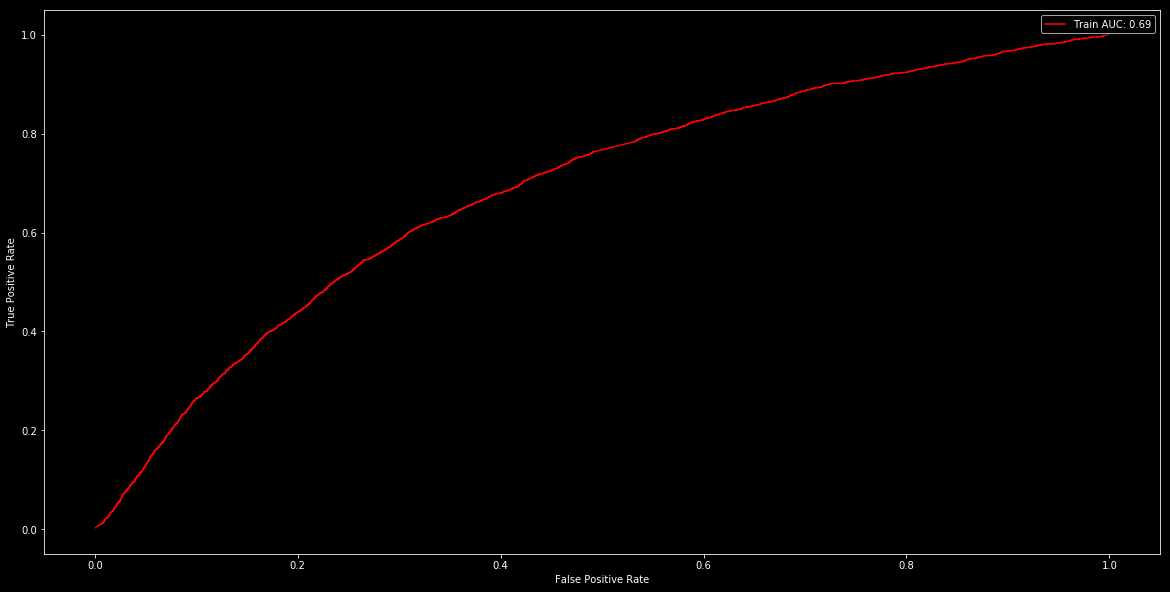

In [498]:
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
# plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

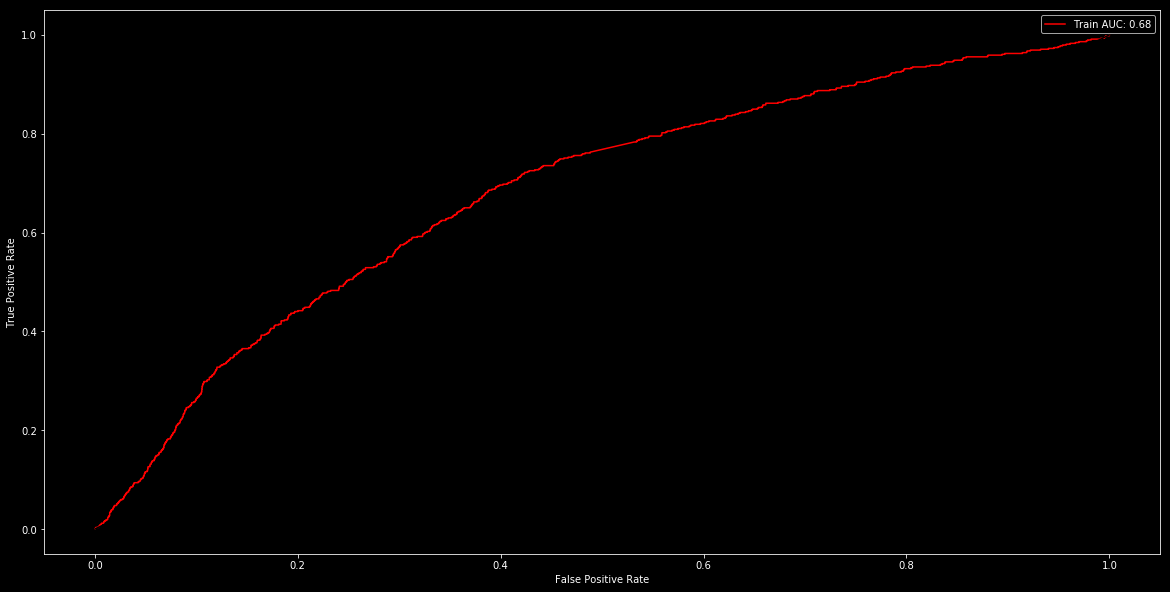

In [499]:
plt.plot(fpr_test, tpr_test,'r-', label = 'Train AUC: %.2f'%auc_test)
# plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()